In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc #한글지원
import platform
import seaborn as sns
plt.rc("font",family='Malgun Gothic') #한글_글꼴
plt.rcParams['axes.unicode_minus'] = False #음수표시

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, Dropout, BatchNormalization, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

file_dir = './data/'

In [2]:
df_ttf = pd.read_csv(file_dir + '01_M02_DC_train_ttf_dup.csv').iloc[:, [0, 1]]
df_ttf_c = df_ttf.dropna()

In [3]:
# train.csv 전처리
df_train = pd.read_csv(file_dir + '01_M02_DC_train.csv')
df_train = df_train.dropna()

std = df_train['IONGAUGEPRESSURE'].std()
df_train_c = df_train[(df_train['IONGAUGEPRESSURE']<=std*3) & (df_train['IONGAUGEPRESSURE']>=std*(-3))]
print(df_train_c.shape)

std = df_train['ETCHSUPPRESSORCURRENT'].std()
df_train_c = df_train_c[(df_train_c['ETCHSUPPRESSORCURRENT']<=std*3) & (df_train_c['ETCHSUPPRESSORCURRENT']>=std*(-3))]
print(df_train_c.shape)

std = df_train['FLOWCOOLPRESSURE'].std()
df_train_c = df_train_c[(df_train_c['FLOWCOOLPRESSURE']<=std*3) & (df_train_c['FLOWCOOLPRESSURE']>=std*(-3))]
print(df_train_c.shape)

df_train_c = df_train_c[df_train_c.duplicated()==False]

# train + ttf
df2 = pd.merge(df_train_c, df_ttf_c, on='time', how='right')
df2 = df2.fillna(method='ffill')
df2 = df2.drop_duplicates()
df2.shape #time중복치가 있어서 df_ttf_C랑 안맞음

(5109968, 24)
(5109932, 24)
(5092348, 24)


(4624305, 25)

In [4]:
### 전처리된 df2파일 복제(변경 : 설비 가동 중으로 한정)
df3 = df2.copy()
# df3 = df2[df2['FIXTURESHUTTERPOSITION'] == 1]

### col분류
control_df = df3[['Tool', 'stage', 'Lot', 'runnum', 'recipe', 'recipe_step']]
cooling_control_df = df3[['FLOWCOOLFLOWRATE','FLOWCOOLPRESSURE']].values
leak_indicators_df = df3[['ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK', 'IONGAUGEPRESSURE']].values
consumable_df = df3[['ETCHSOURCEUSAGE', 'ETCHAUXSOURCETIMER', 'ETCHAUX2SOURCETIMER']].values
settings_df = df3[['FIXTURETILTANGLE', 'ROTATIONSPEED', 'ACTUALROTATIONANGLE', 'FIXTURESHUTTERPOSITION']].values

### 차원 줄여서 복잡도 줄이기
pca = PCA(n_components=1)
principalComponents_cooling_control = pca.fit_transform(cooling_control_df)
principalComponents_leak_indicators = pca.fit_transform(leak_indicators_df)
principalComponents_consumables = pca.fit_transform(consumable_df)
principalComponents_settings = pca.fit_transform(settings_df)

### 모델링용 df
model_df = df3[['stage', 'runnum', 'recipe', 'recipe_step']]
model_df['principalComponents_cooling_control'] = principalComponents_cooling_control
model_df['principalComponents_leak_indicators'] = principalComponents_leak_indicators
model_df['principalComponents_consumables'] = principalComponents_consumables
model_df['principalComponents_settings'] = principalComponents_settings
model_df.shape

C:\Users\USER\AppData\Local\Temp\ipykernel_20932\1163781347.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['principalComponents_cooling_control'] = principalComponents_cooling_control
C:\Users\USER\AppData\Local\Temp\ipykernel_20932\1163781347.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['principalComponents_leak_indicators'] = principalComponents_leak_indicators
C:\Users\USER\AppData\Local\Temp\ipykernel_20932\1163781347.py:23: SettingWithCopyWarning: 
A value is trying to b

(4624305, 8)

# 기울기

In [5]:
# end row_index
idx_e = df_ttf_c[df_ttf_c['TTF_FlowCool Pressure Dropped Below Limit']==0].index.values

# start row_index
idx_s = idx_e +1
idx_s = np.delete(idx_s, -1, axis=0)
idx_s = np.append([0],idx_s, axis=0)

In [6]:
a = []
x = idx_e - idx_s

for i in range(len(idx_s)):
    y = df_ttf_c.iloc[idx_s[i], 1]
    a.append(round(y/x[i], 3))
a

[4.76,
 0.614,
 3.018,
 4.0,
 6.107,
 5.66,
 4.0,
 4.0,
 4.0,
 0.004,
 0.069,
 4.326,
 0.256,
 7.216,
 6.274,
 5.857,
 0.001,
 3.412,
 0.387,
 5.158,
 0.095,
 3.812,
 11.084]

In [25]:
idx_s

array([      0,  130943,  143980,  145991,  146472,  815603,  821470,
        821959,  822071,  822493, 2200610, 2641940, 2689181, 2822934,
       2889664, 2911091, 2996305, 4493650, 4535502, 4547024, 4548175,
       4601880, 4615972], dtype=int64)

In [26]:
idx_e

array([ 130942,  143979,  145990,  146471,  815602,  821469,  821958,
        822070,  822492, 2200609, 2641939, 2689180, 2822933, 2889663,
       2911090, 2996304, 4493649, 4535501, 4547023, 4548174, 4601879,
       4615971, 4617749], dtype=int64)

In [7]:
# 기울기 변수 생성
model_df['m'] = 0

for i in range(len(idx_s)):
    if i == len(idx_s)-1:
        model_df.iloc[idx_s[i]:, -1] = a[i]
    else:
        model_df.iloc[idx_s[i]:idx_s[i+1], -1] = a[i]

C:\Users\USER\AppData\Local\Temp\ipykernel_20932\704406470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['m'] = 0


# 군집

In [8]:
from sklearn.cluster import KMeans

c:\Users\USER\anaconda3\envs\edu_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\envs\edu_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\envs\edu_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\USER\anaconda3\envs\edu_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

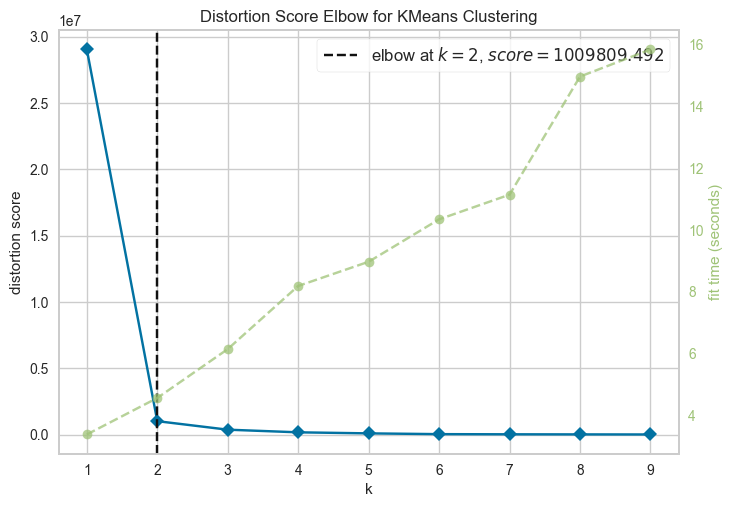

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()

visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(model_df[['m']])
visualizer.show()

In [10]:
km = KMeans(n_clusters=2, n_init=10, random_state=42)

km.fit(model_df[['m']])

# 군집 결과 확인
model_df['km'] = km.labels_

C:\Users\USER\AppData\Local\Temp\ipykernel_20932\3566324299.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['km'] = km.labels_


In [11]:
model_df[model_df['km'] == 0]['m'].value_counts()

m
0.001    1497345
0.004    1378117
0.069     441330
0.256     133753
0.095      53705
0.614      13037
0.387      11522
Name: count, dtype: int64

In [95]:
model_df[model_df['km'] == 1]['m'].value_counts()

m
6.107     669131
4.760     130943
5.857      85214
7.216      66730
4.326      47241
3.412      41852
6.274      21427
3.812      14092
11.084      8333
5.660       5867
3.018       2011
4.000       1504
5.158       1151
Name: count, dtype: int64

In [96]:
### 시각화
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=42)

model_df2 = model_df.iloc[:,:-1].sample(50000)
X_t = tsne.fit_transform(model_df2)
tsne_df = pd.DataFrame(X_t, columns = ['val0', 'val1', 'val2'])
tsne_df['km'] = model_df['km']

MovieWriter ffmpeg unavailable; using Pillow instead.


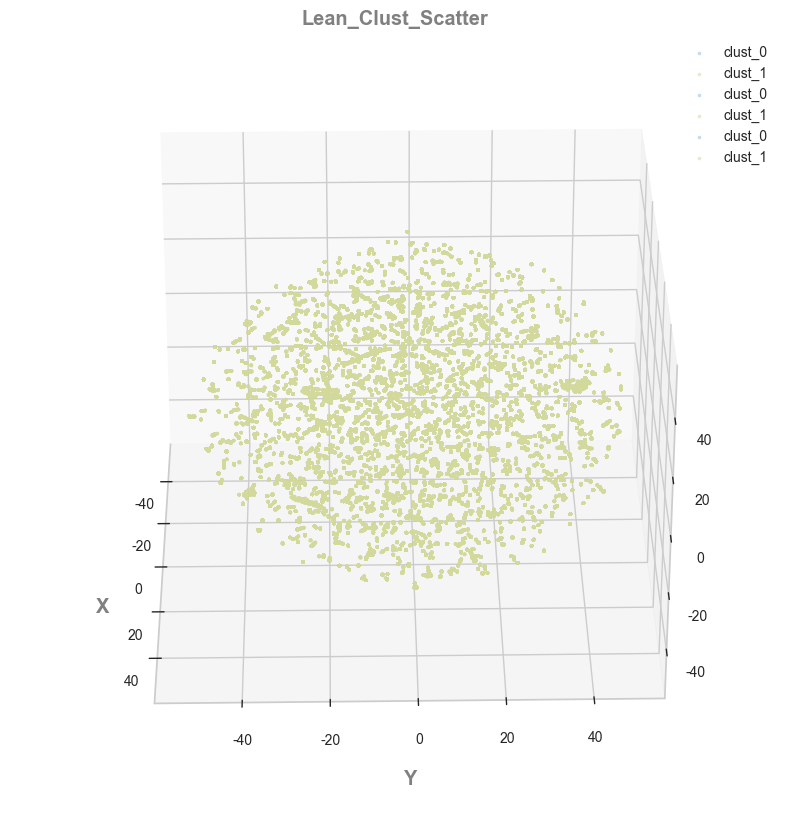

In [140]:
from matplotlib import animation

def init():
    ax.set_xlabel("X", fontdict=fontlabel, labelpad=16)
    ax.set_ylabel("Y", fontdict=fontlabel, labelpad=16)
    ax.set_title("Lean_Clust_Scatter", fontdict=fontlabel)

    for i, cc in zip([0,1], ['#9ABAD9', '#D2D99A']): #, '#D99E9A'
        temp = tsne_df[tsne_df['km'] == i]
        ax.scatter(temp['val0'], temp['val1'], temp['val2'], c=cc, label='clust_{}'.format(i), s=5, alpha=0.5)
        plt.legend(loc="upper right")
    
    return fig,

def animate(i):
    ax.view_init(elev=30., azim=i)
    return fig,

fig, ax = plt.subplots(ncols=1, figsize=(10, 10), subplot_kw={"projection":"3d"})

fontlabel = {"fontsize":"large", "color":"gray", "fontweight":"bold"}

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('Lean_Clust_Scatter.gif', fps=30)

# 회귀분석

In [20]:
### df
model_df2 = model_df.astype({'stage':'int', 'recipe':'int'})
model_df2['ttf'] = df2.iloc[:, -1]
model_df2 = model_df2[model_df2['km'] == 0]

### 정규화
ss = StandardScaler()
X = ss.fit_transform(model_df2.iloc[:, [0,2,4,5,6,7]])
y = model_df2[['ttf']]/86400

결정계수_train :  0.9537653225768624
결정계수_test :  0.9274561298965661
MSE :  55.84925768222264
RMSE :  7.473236091695662


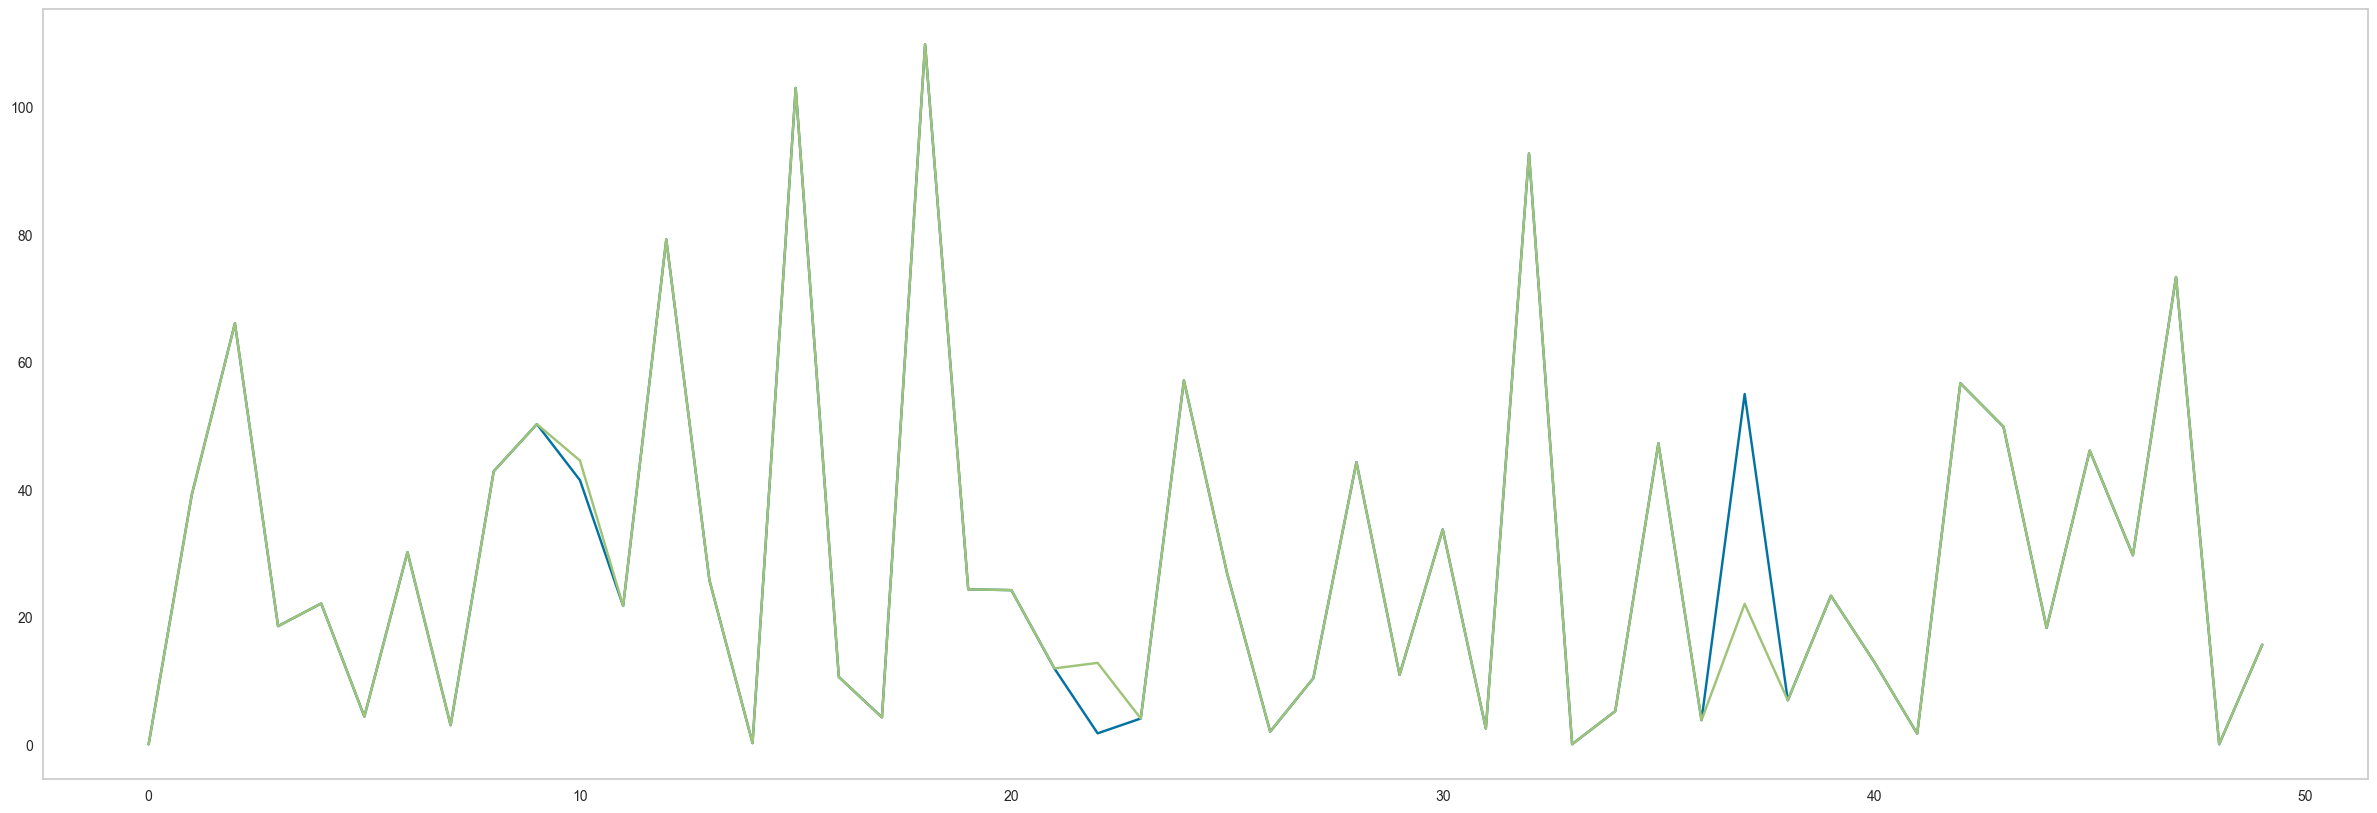

In [21]:
from sklearn.neighbors import KNeighborsRegressor

train_input, test_input, train_target, test_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

# 훈련
kn.fit(train_input, train_target)

# 찾은 최적모델 사용
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

c:\Users\USER\anaconda3\envs\edu_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


결정계수_train :  0.5478800967950026
결정계수_test :  0.5482946302995066
MSE :  347.75384264551866
RMSE :  18.648159229412393


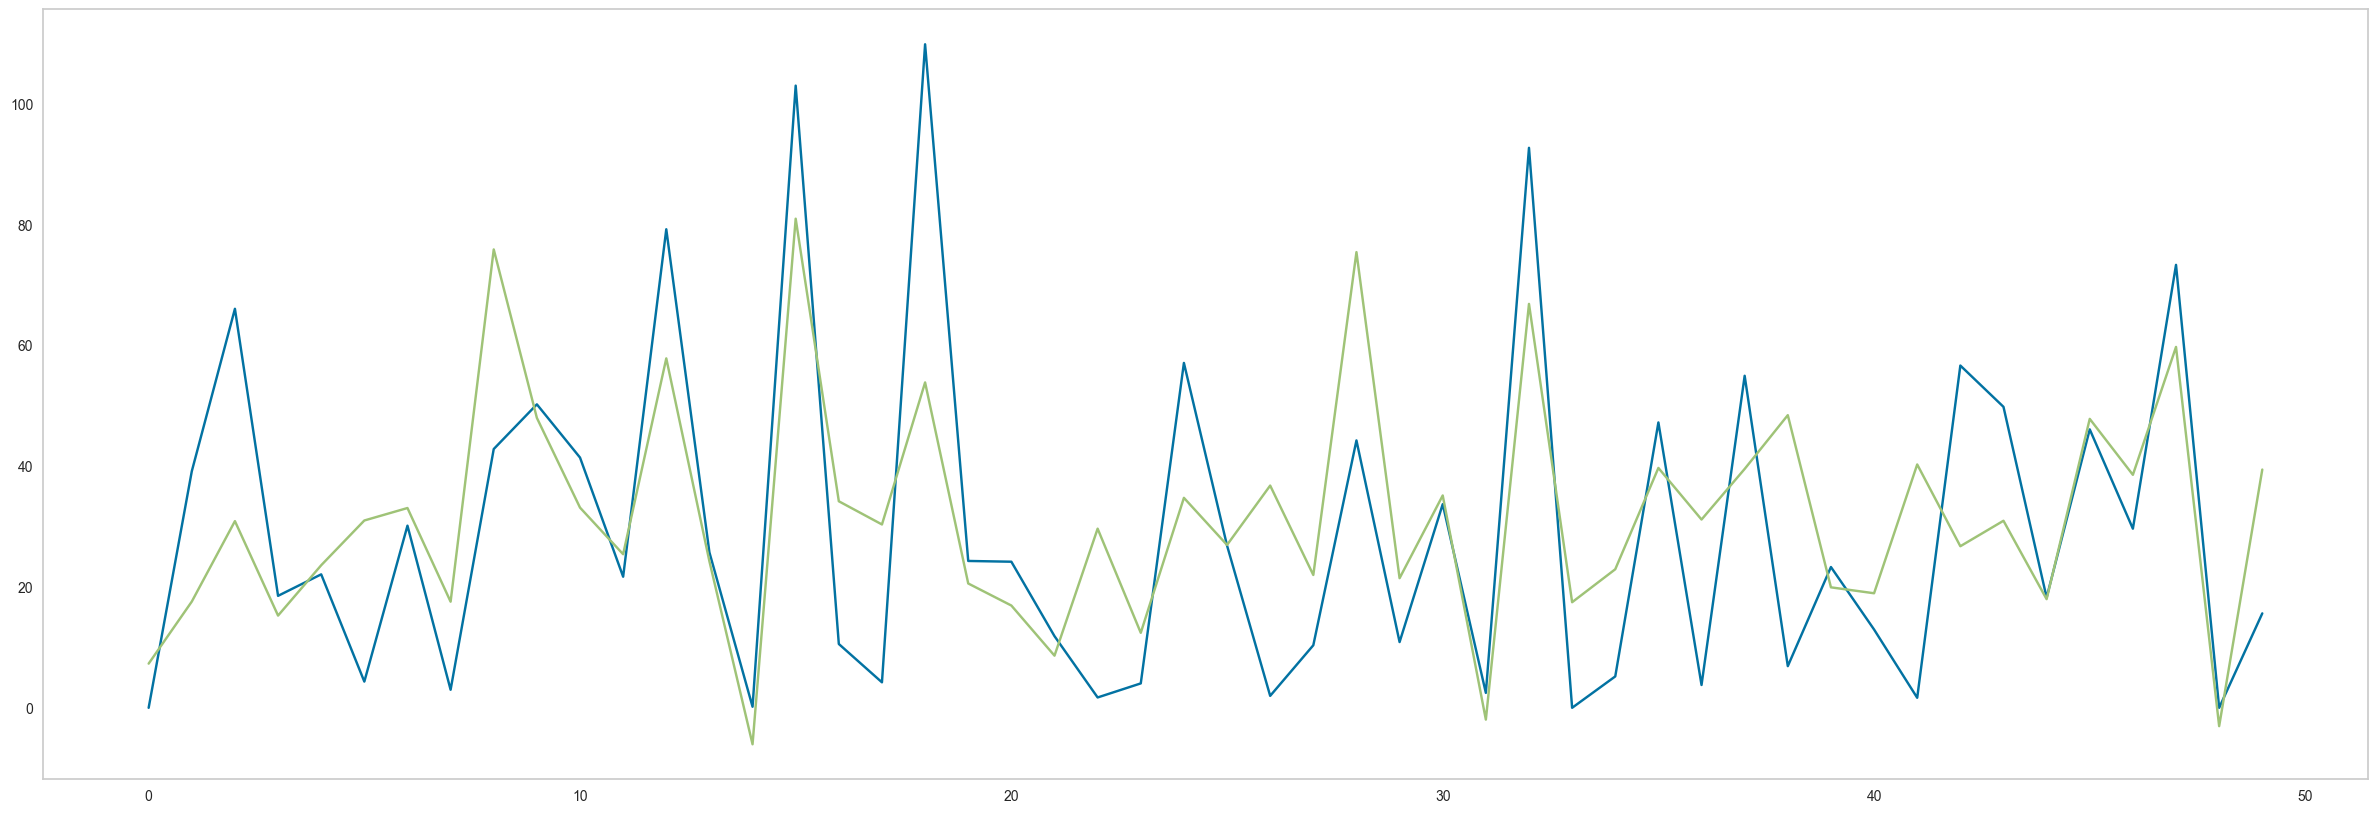

In [32]:
from sklearn.neural_network import MLPRegressor

y1 = (model_df2['ttf']/86400).values

train_input, test_input, train_target, test_target = train_test_split(X, y1,
                                                                      test_size=0.25, random_state=42)

# 모델생성
kn = MLPRegressor(random_state=42)

# 훈련
kn.fit(train_input, train_target)

# 찾은 최적모델 사용
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

In [22]:
with open('knn_km0.pickle','wb') as fw:
    pickle.dump(kn, fw)

------

In [17]:
### df
model_df2 = model_df.astype({'stage':'int', 'recipe':'int'})
model_df2['ttf'] = df2.iloc[:, -1]
model_df2 = model_df2[model_df2['km'] == 1]

### 정규화
ss = StandardScaler()
X = ss.fit_transform(model_df2.iloc[:, [0,2,4,5,6,7]])
y = model_df2[['ttf']]/86400

결정계수_train :  0.9877750699825482
결정계수_test :  0.9802720619464093
MSE :  3.6142243572185584
RMSE :  1.9011113479274586


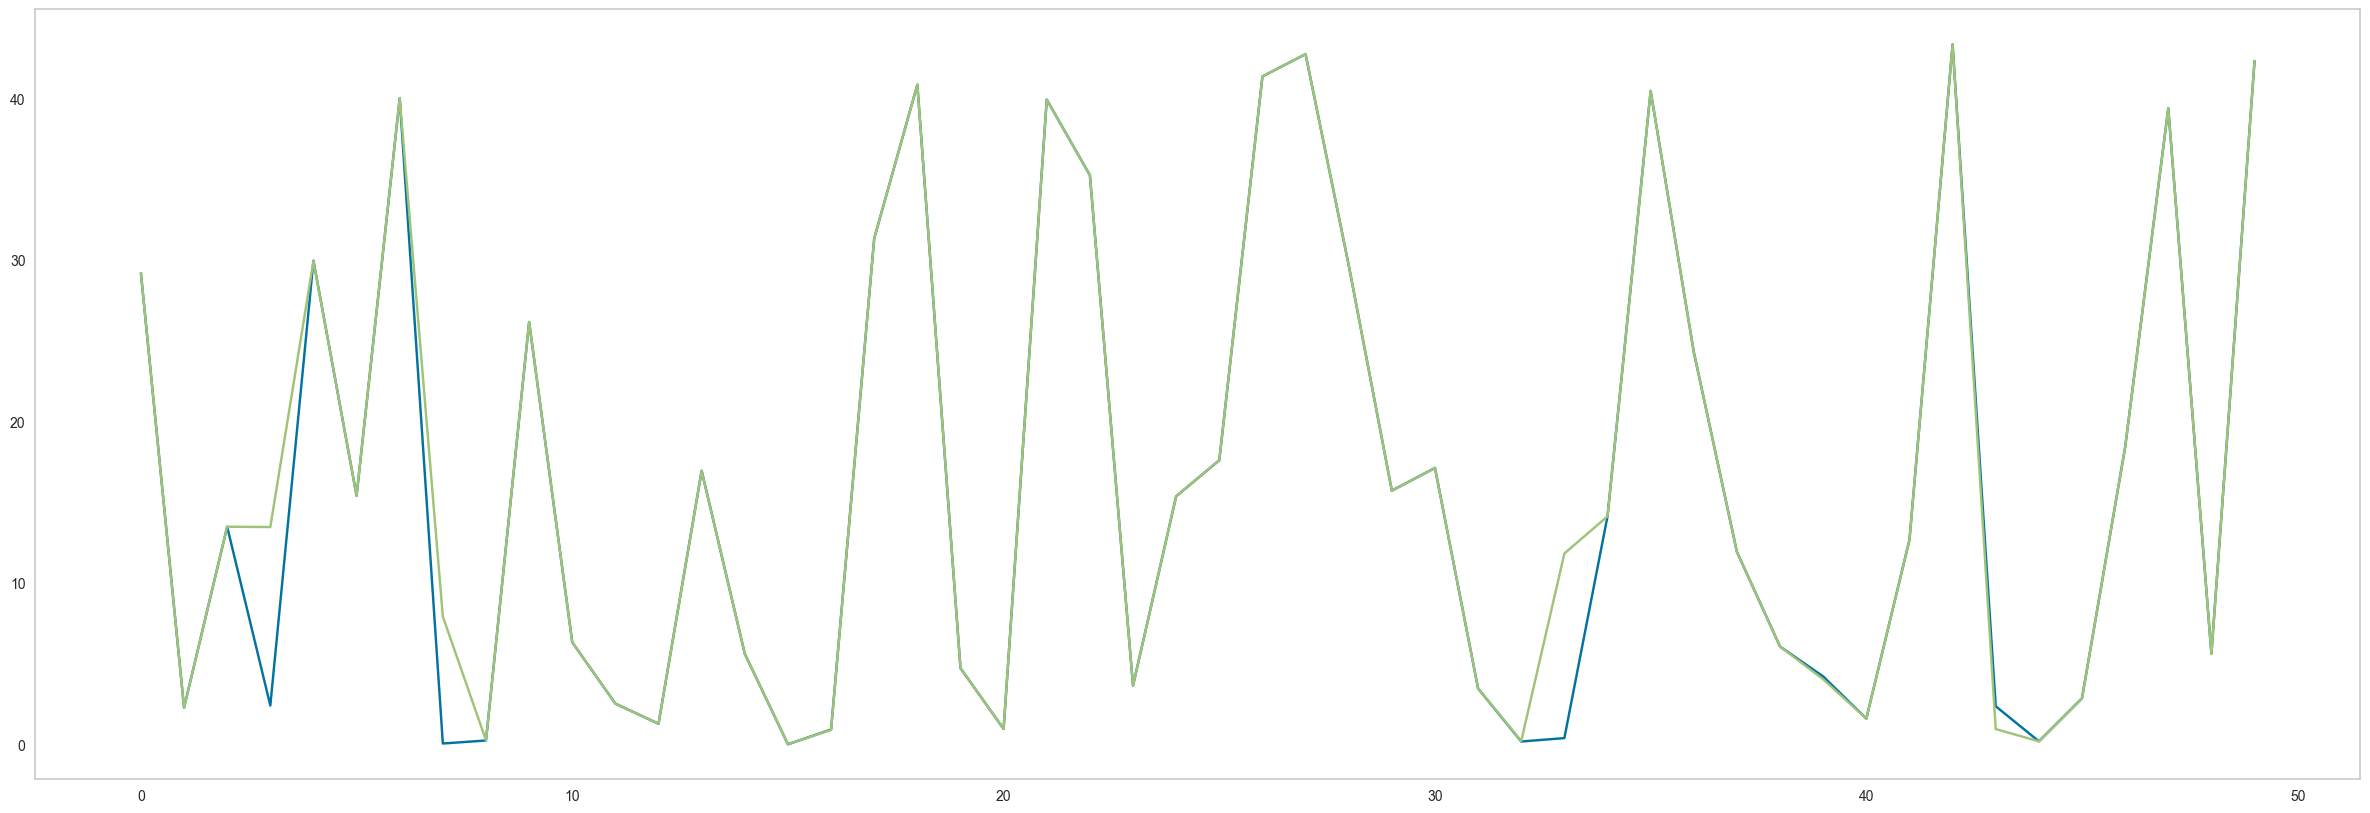

In [18]:
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

train_input, test_input, train_target, test_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

# 훈련
kn.fit(train_input, train_target)

# 찾은 최적모델 사용
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

결정계수_val :  0.9804734552109273
결정계수_test :  0.9800696600388402
0.988 0.98


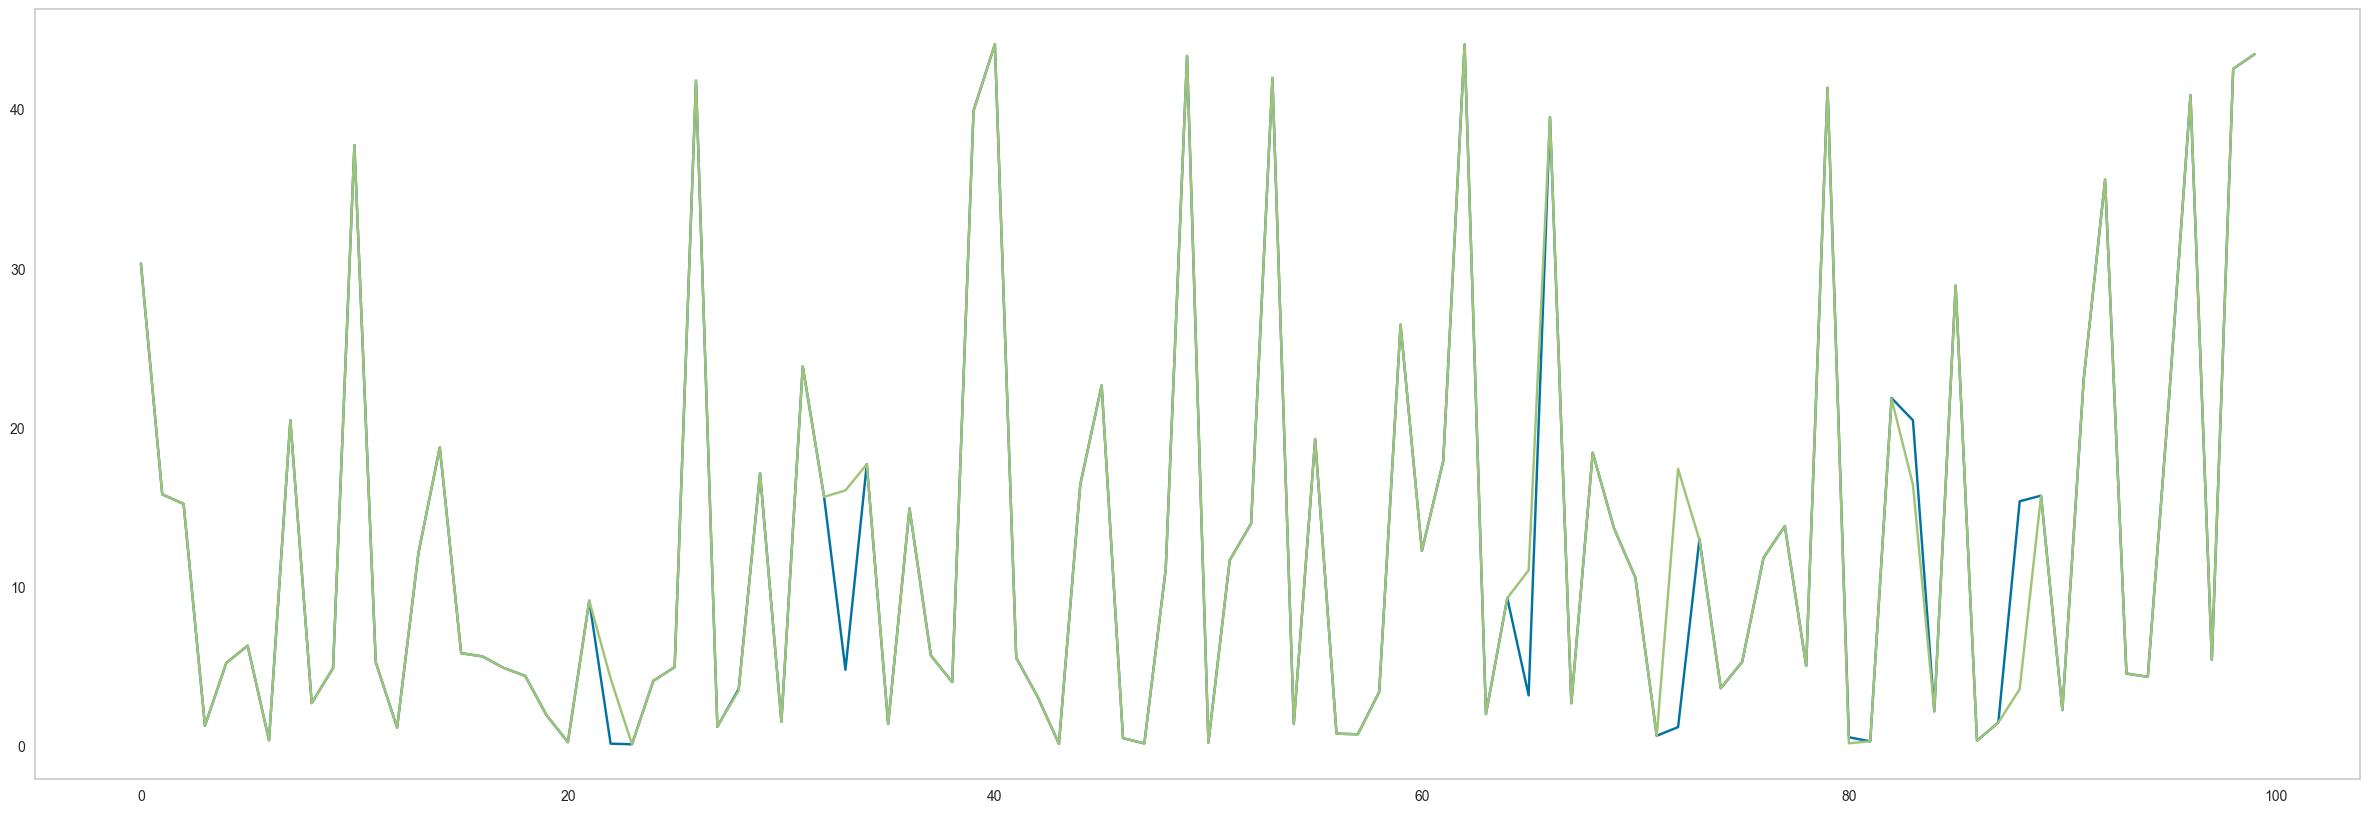

In [143]:
### train:val:test = 7.5:1.25:1.25
train_input, val_input, train_target, val_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target,
                                                                      test_size=0.5, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

# 훈련
kn.fit(train_input, train_target)

# 결정계수 (0<=R²<=1)
print('결정계수_val : ', kn.score(val_input, val_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()
# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:100])), test_target[:100]) #true
plt.plot(range(len(test_target[:100])), test_pred[:100], linestyle='--') #predict
plt.grid()

# 전체 데이터셋 KNN_Regressor

In [12]:
### df
model_df2 = model_df.astype({'stage':'int', 'recipe':'int'})
model_df2['ttf'] = df2.iloc[:, -1]

### 정규화
ss = StandardScaler()
X = ss.fit_transform(model_df2.iloc[:, [0,2,4,5,6,7]])
y = model_df2[['ttf']]/86400

결정계수_train :  0.9388474404475616
결정계수_test :  0.9028062512559415
MSE :  67.50847125049495
RMSE :  8.216353890290689


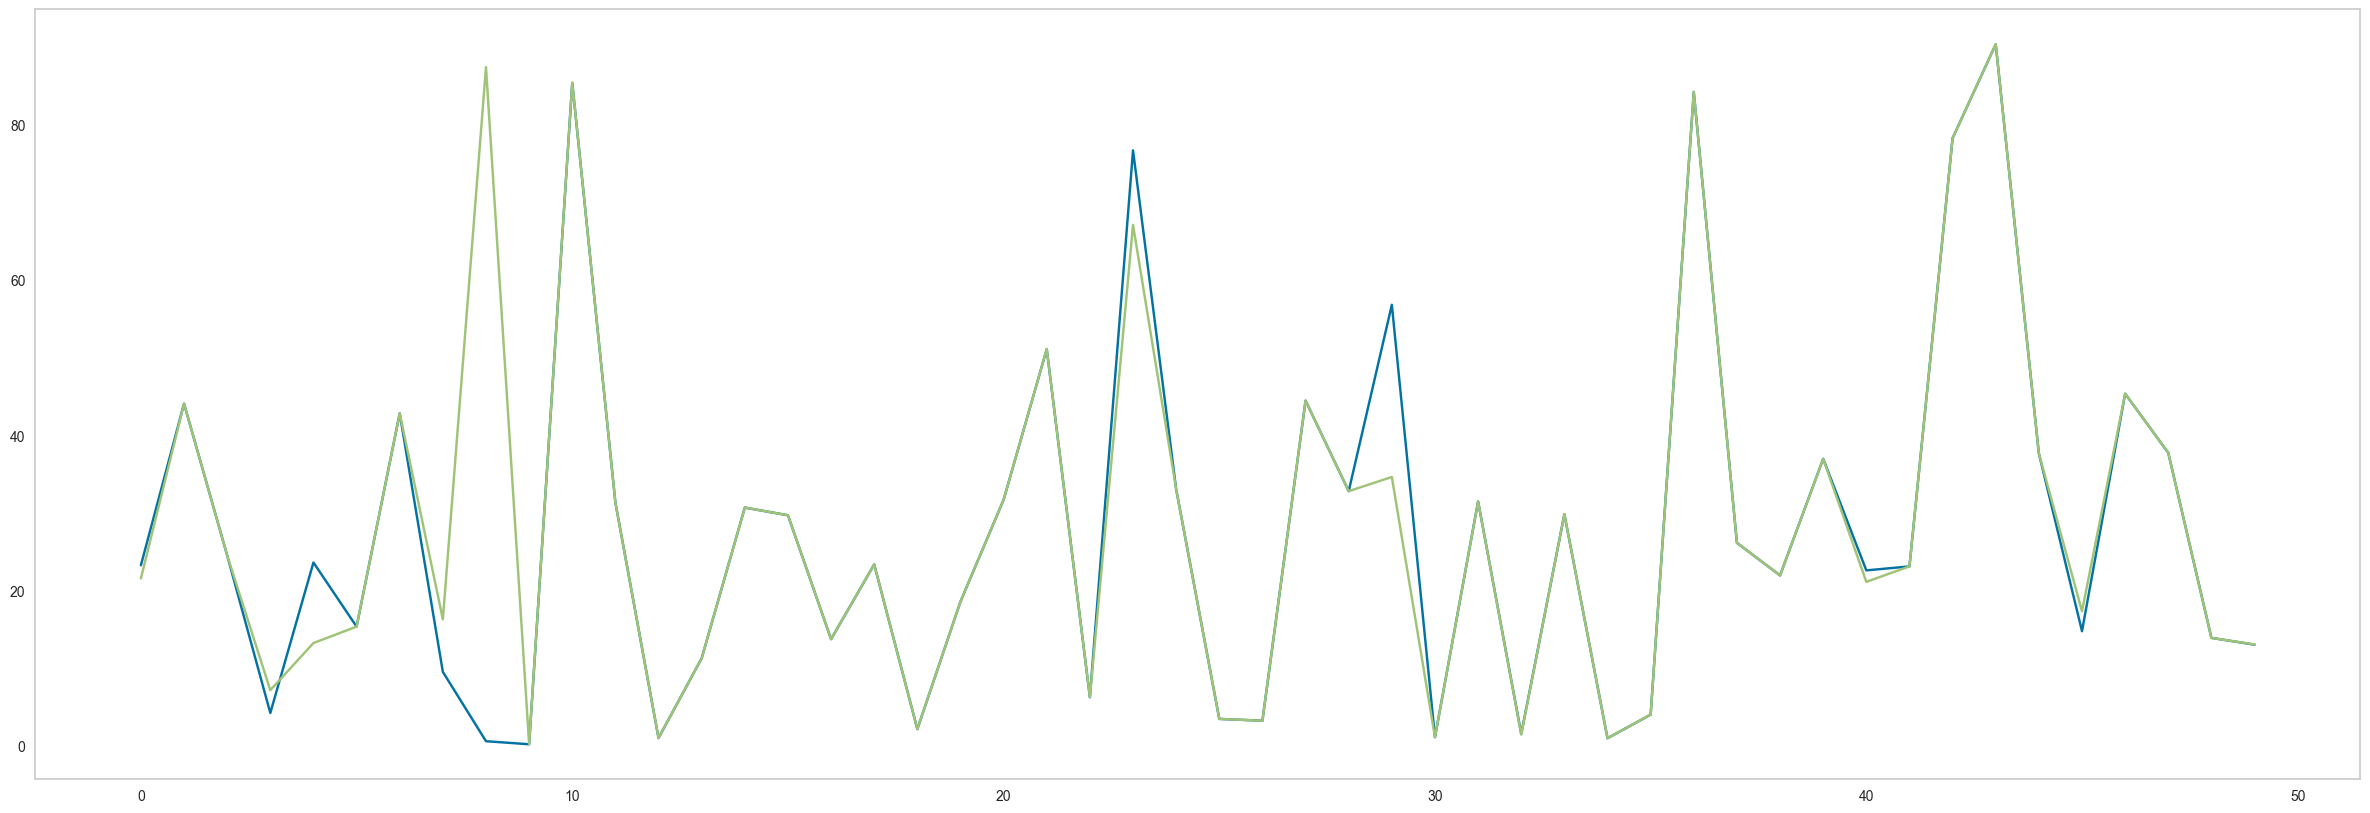

In [13]:
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

train_input, test_input, train_target, test_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

# 훈련
kn.fit(train_input, train_target)

# 찾은 최적모델 사용
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

Iteration 1, loss = 359.48183398
Validation score: 0.100942
Iteration 2, loss = 341.22704951
Validation score: 0.125825
Iteration 3, loss = 331.77842063
Validation score: 0.150253
Iteration 4, loss = 322.75465943
Validation score: 0.173907
Iteration 5, loss = 312.14327620
Validation score: 0.206607
Iteration 6, loss = 297.86864668
Validation score: 0.246287
Iteration 7, loss = 282.42011179
Validation score: 0.286035
Iteration 8, loss = 268.39535496
Validation score: 0.319318
Iteration 9, loss = 257.17343464
Validation score: 0.343137
Iteration 10, loss = 249.68943907
Validation score: 0.359727
Iteration 11, loss = 244.15986183
Validation score: 0.372523
Iteration 12, loss = 239.58221406
Validation score: 0.383473
Iteration 13, loss = 235.93347768
Validation score: 0.391705
Iteration 14, loss = 232.92027576
Validation score: 0.399022
Iteration 15, loss = 230.33246421
Validation score: 0.405502
Iteration 16, loss = 227.49772192
Validation score: 0.414436
Iteration 17, loss = 224.36049521

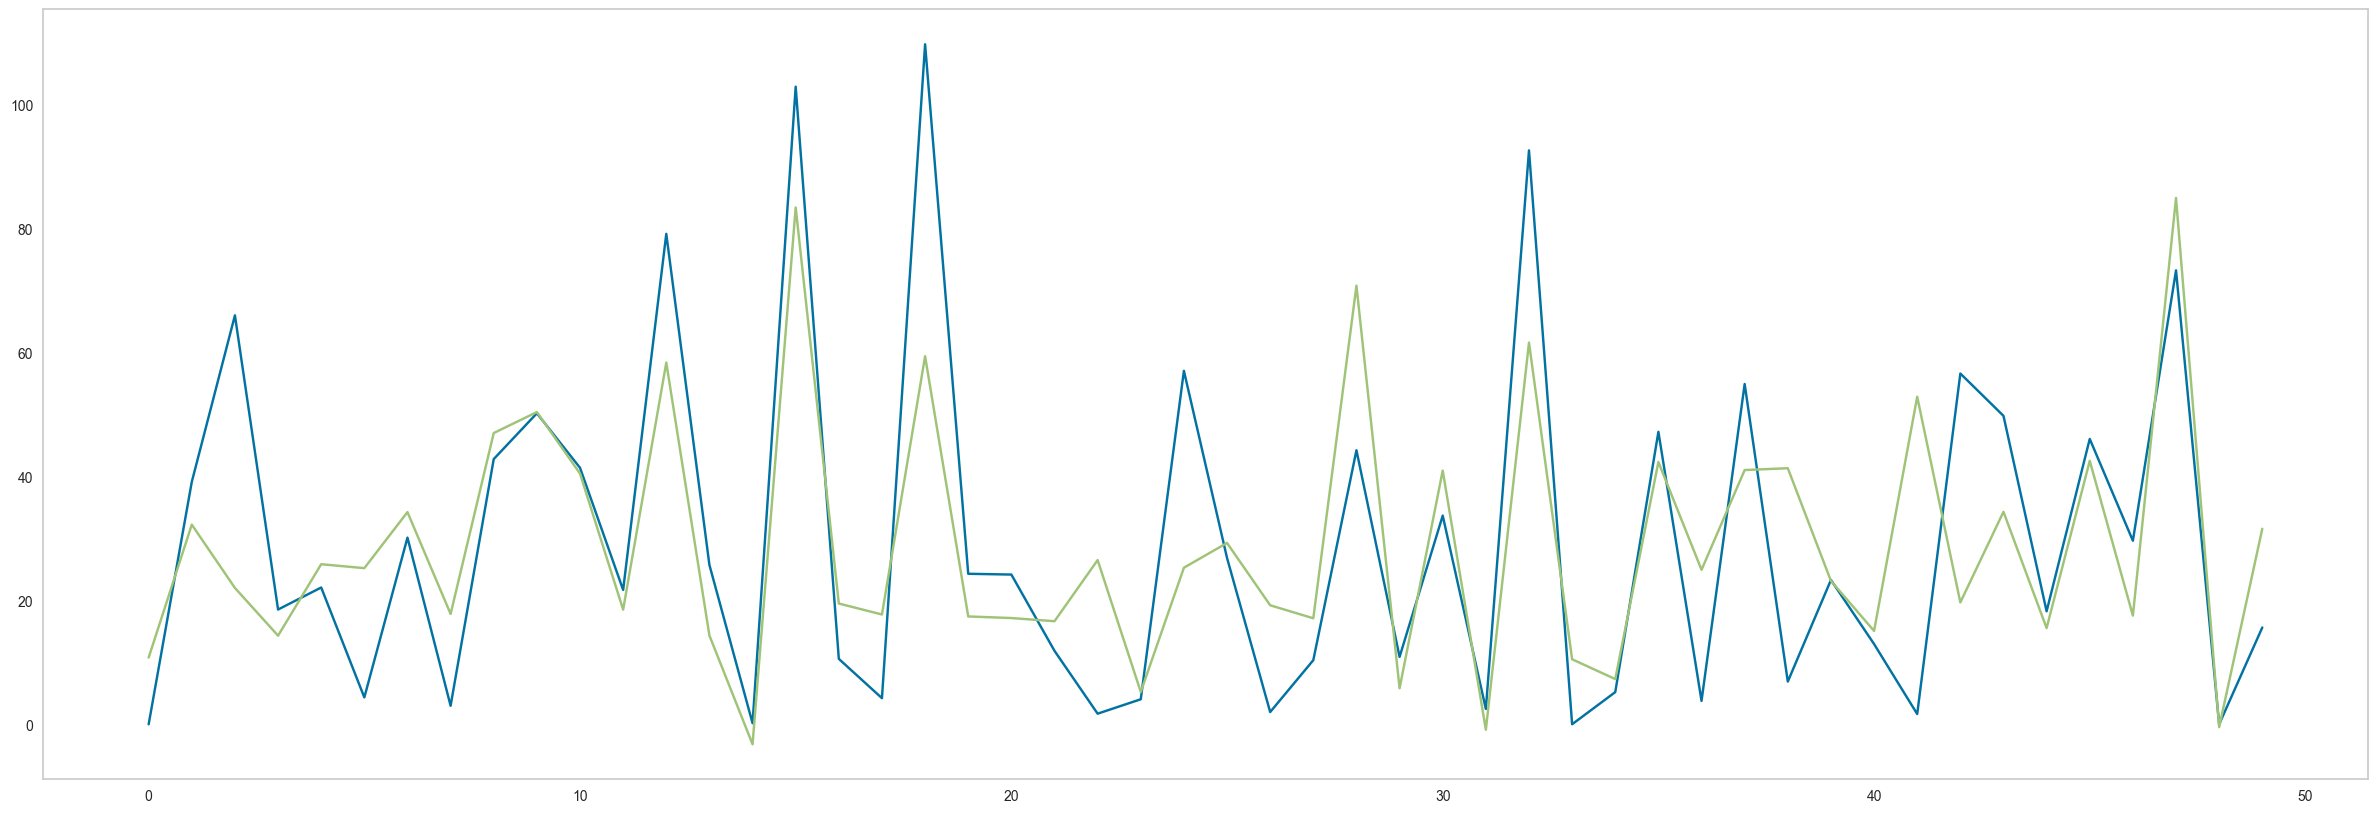

In [50]:
from sklearn.neural_network import MLPRegressor

y1 = (model_df2['ttf']/86400).values

train_input, test_input, train_target, test_target = train_test_split(X, y1,
                                                                      test_size=0.25, random_state=42)


# 모델생성
kn = MLPRegressor(random_state=42, activation='logistic', early_stopping = True, verbose=2, max_iter=1000)

# 훈련
kn.fit(train_input, train_target)

# 찾은 최적모델 사용
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()
plt.show()

c:\Users\USER\anaconda3\envs\edu_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


결정계수_train :  0.6244935690982205
결정계수_test :  0.6241622641909282
MSE :  289.34572313244126
RMSE :  17.010165288216374


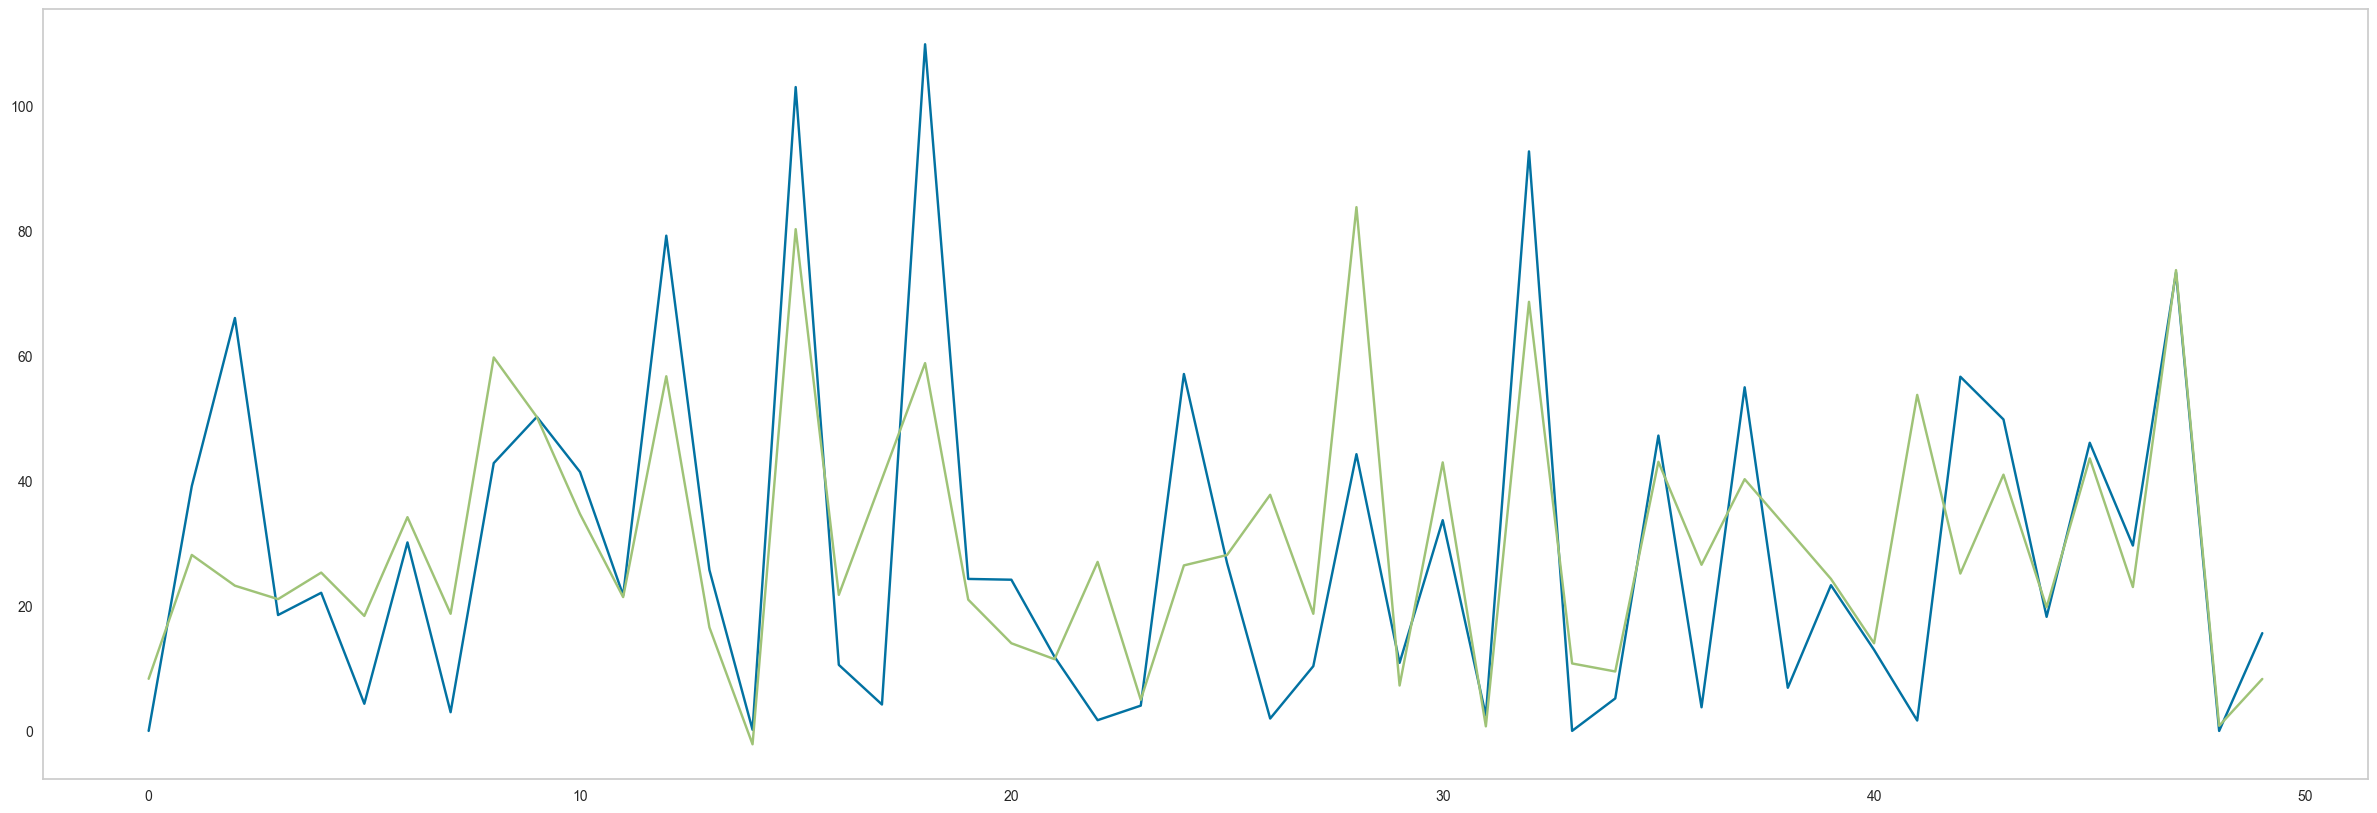

In [55]:
from sklearn.neural_network import MLPRegressor

y1 = (model_df2['ttf']/86400).values

train_input, test_input, train_target, test_target = train_test_split(X, y1,
                                                                      test_size=0.25, random_state=42)

# 모델생성
kn = MLPRegressor(random_state=42, activation='logistic', early_stopping = True, max_iter=500, alpha=0.01) #verbose=2

# 훈련
kn.fit(train_input, train_target)

# 찾은 최적모델 사용
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()
plt.show()

In [52]:
import pickle
with open('mlp.pickle','wb') as fw:
    pickle.dump(kn, fw)

# 하이퍼파라미터 튜닝

In [147]:
### df
model_df2 = model_df.astype({'stage':'int', 'recipe':'int'})
model_df2['ttf'] = df2.iloc[:, -1]
model_df2 = model_df2[model_df2['km'] == 0]

### 정규화
ss = StandardScaler()
X = ss.fit_transform(model_df2.iloc[:, [0,2,4,5,6,7]])
y = model_df2[['ttf']]/86400

결정계수_train :  0.9997905215519309
결정계수_val :  0.9498093195991949
결정계수_test :  0.9499850668201893


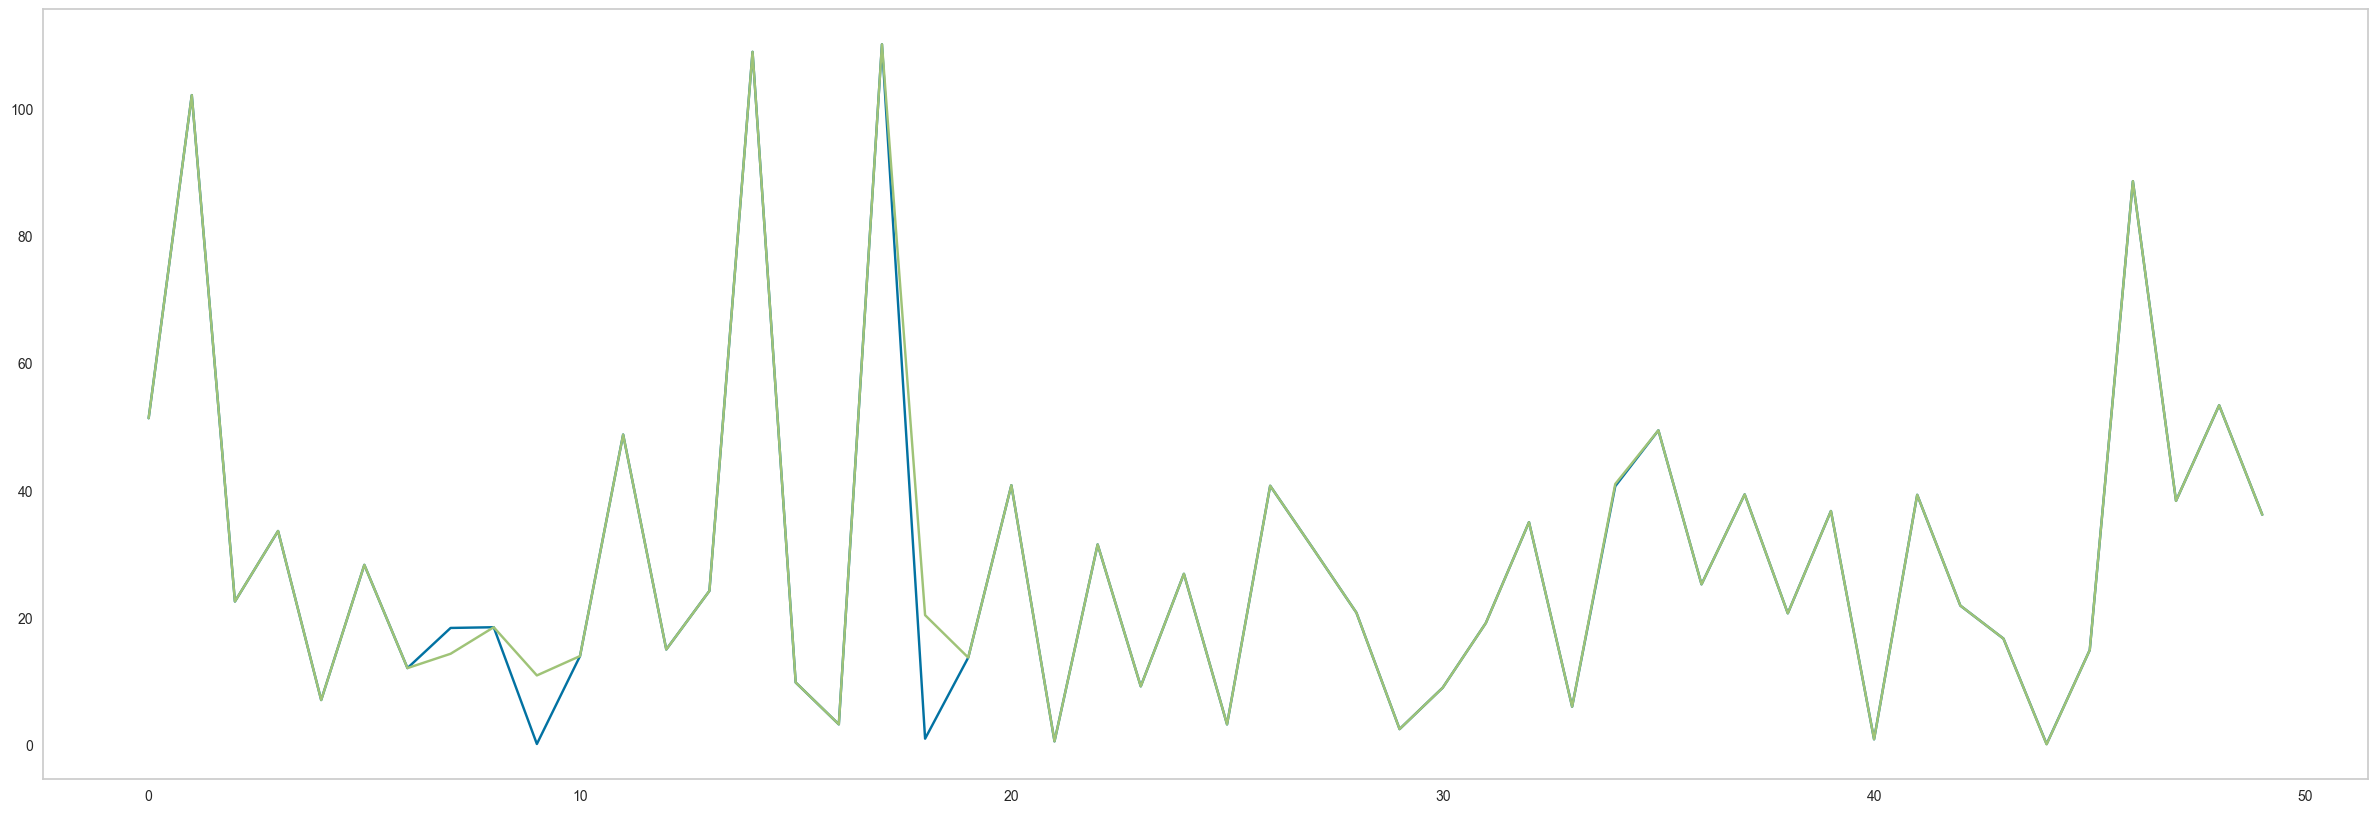

In [149]:
from sklearn.model_selection import GridSearchCV

### train:val:test = 7.5:1.25:1.25
train_input, val_input, train_target, val_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target,
                                                                      test_size=0.5, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

param_grid = {'n_neighbors':[3,4,5],
              'metric':['minkowski','manhattan','euclidean'],
              'weights':['uniform','distance']}

grid = GridSearchCV(kn, param_grid=param_grid, cv=3, scoring='r2')

grid.fit(train_input, train_target)

# 찾은 최적모델 사용
kn = grid.best_estimator_
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_val : ', kn.score(val_input, val_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

In [150]:
### df
model_df2 = model_df.astype({'stage':'int', 'recipe':'int'})
model_df2['ttf'] = df2.iloc[:, -1]

### 정규화
ss = StandardScaler()
X = ss.fit_transform(model_df2.iloc[:, [0,2,4,5,6,7]])
y = model_df2[['ttf']]/86400

결정계수_train :  0.9998058986576948
결정계수_val :  0.930625985514772
결정계수_test :  0.9308227109938991


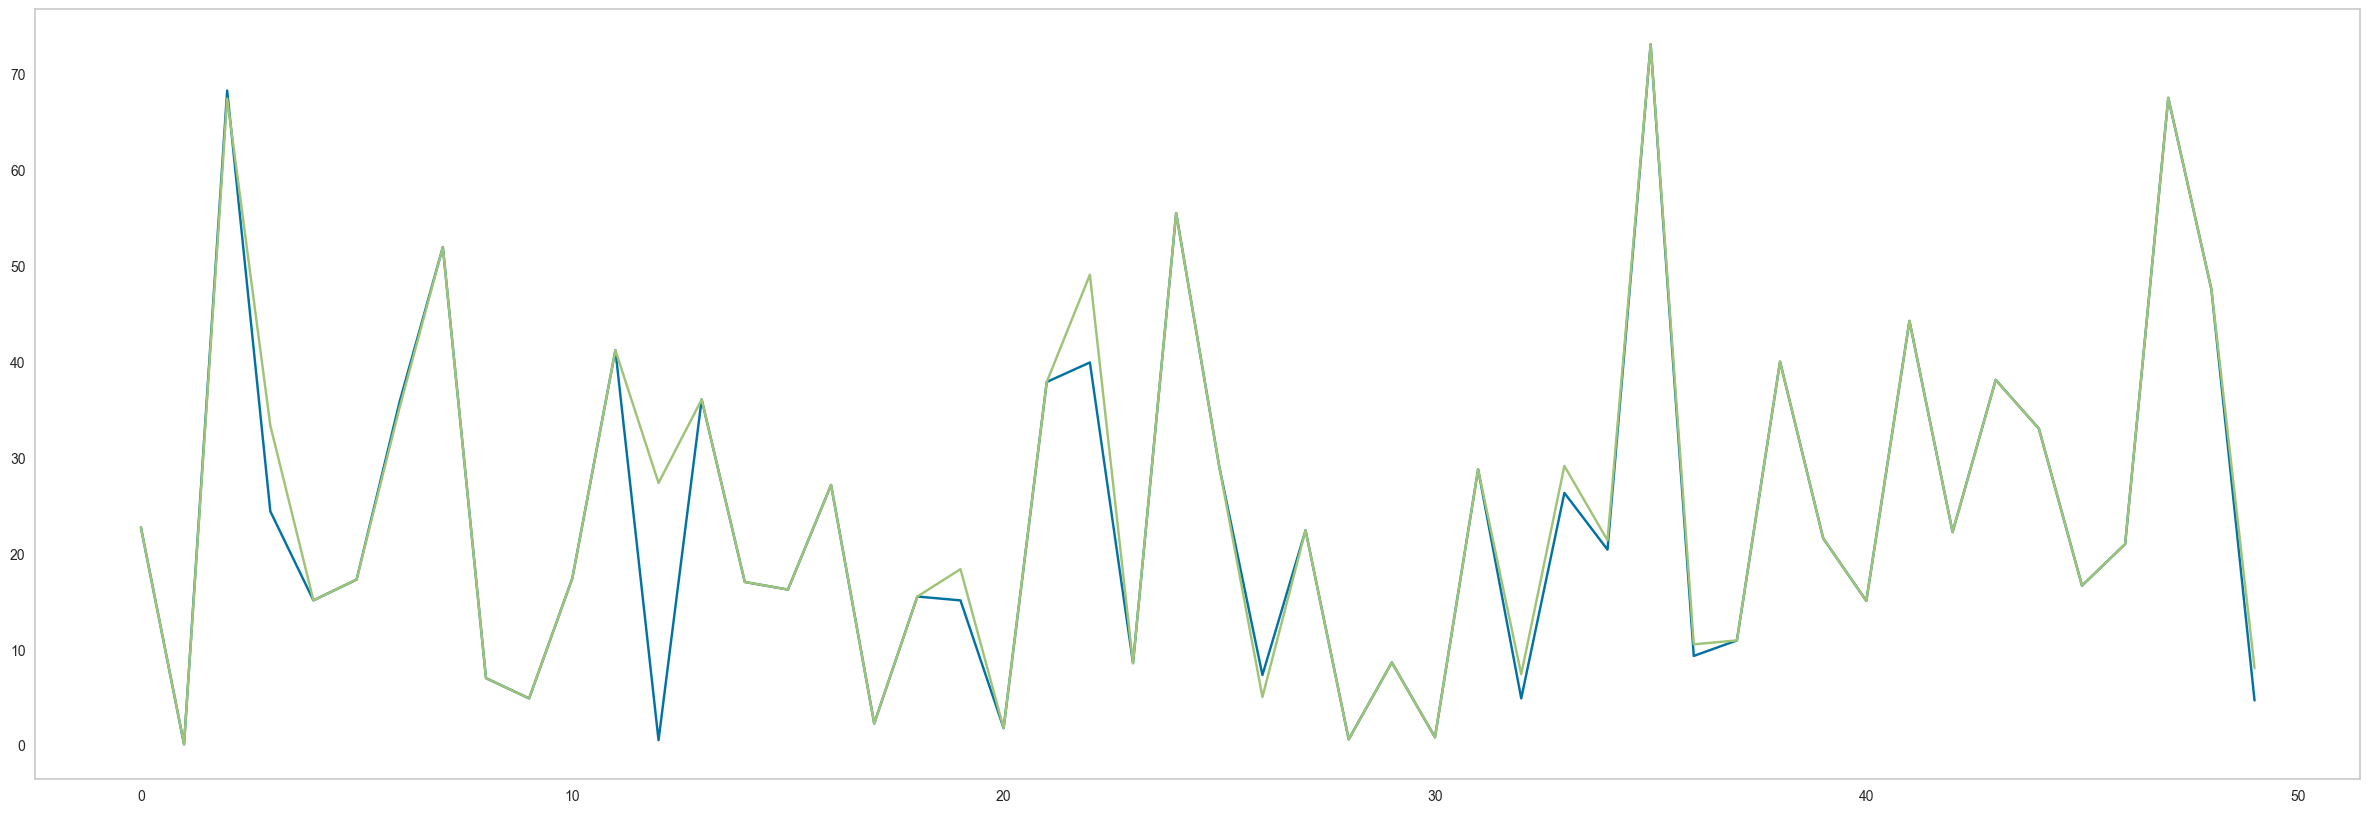

In [151]:
### train:val:test = 7.5:1.25:1.25
train_input, val_input, train_target, val_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target,
                                                                      test_size=0.5, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

param_grid = {'n_neighbors':[3,4,5],
              'metric':['minkowski','manhattan','euclidean'],
              'weights':['uniform','distance']}

grid = GridSearchCV(kn, param_grid=param_grid, cv=3, scoring='r2')

grid.fit(train_input, train_target)

# 찾은 최적모델 사용
kn = grid.best_estimator_
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_val : ', kn.score(val_input, val_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

# 모델저장

In [167]:
import pickle
with open('saved_model.pickle','wb') as fw:
    pickle.dump(kn, fw)

In [162]:
kn.n_neighbors

5

In [ ]:
kn

KNeighborsRegressor(metric='manhattan', weights='distance')

# 연속형 변수만 넣었을 때

In [173]:
### df
model_df2 = model_df.astype({'stage':'int', 'recipe':'int'})
model_df2['ttf'] = df2.iloc[:, -1]

### 정규화
ss = StandardScaler()
X = ss.fit_transform(model_df2.iloc[:, [4,5,6,7]])
y = model_df2[['ttf']]/86400

{'cv': 3, 'error_score': nan, 'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsRegressor(), 'n_jobs': None, 'param_grid': {'n_neighbors': [3, 4, 5], 'metric': ['minkowski', 'manhattan', 'euclidean'], 'weights': ['uniform', 'distance']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'r2', 'verbose': 0}
결정계수_train :  0.999797969218218
결정계수_val :  0.9229582117705559
결정계수_test :  0.9240867730466475
MSE :  52.67217172302711
RMSE :  7.257559625867851


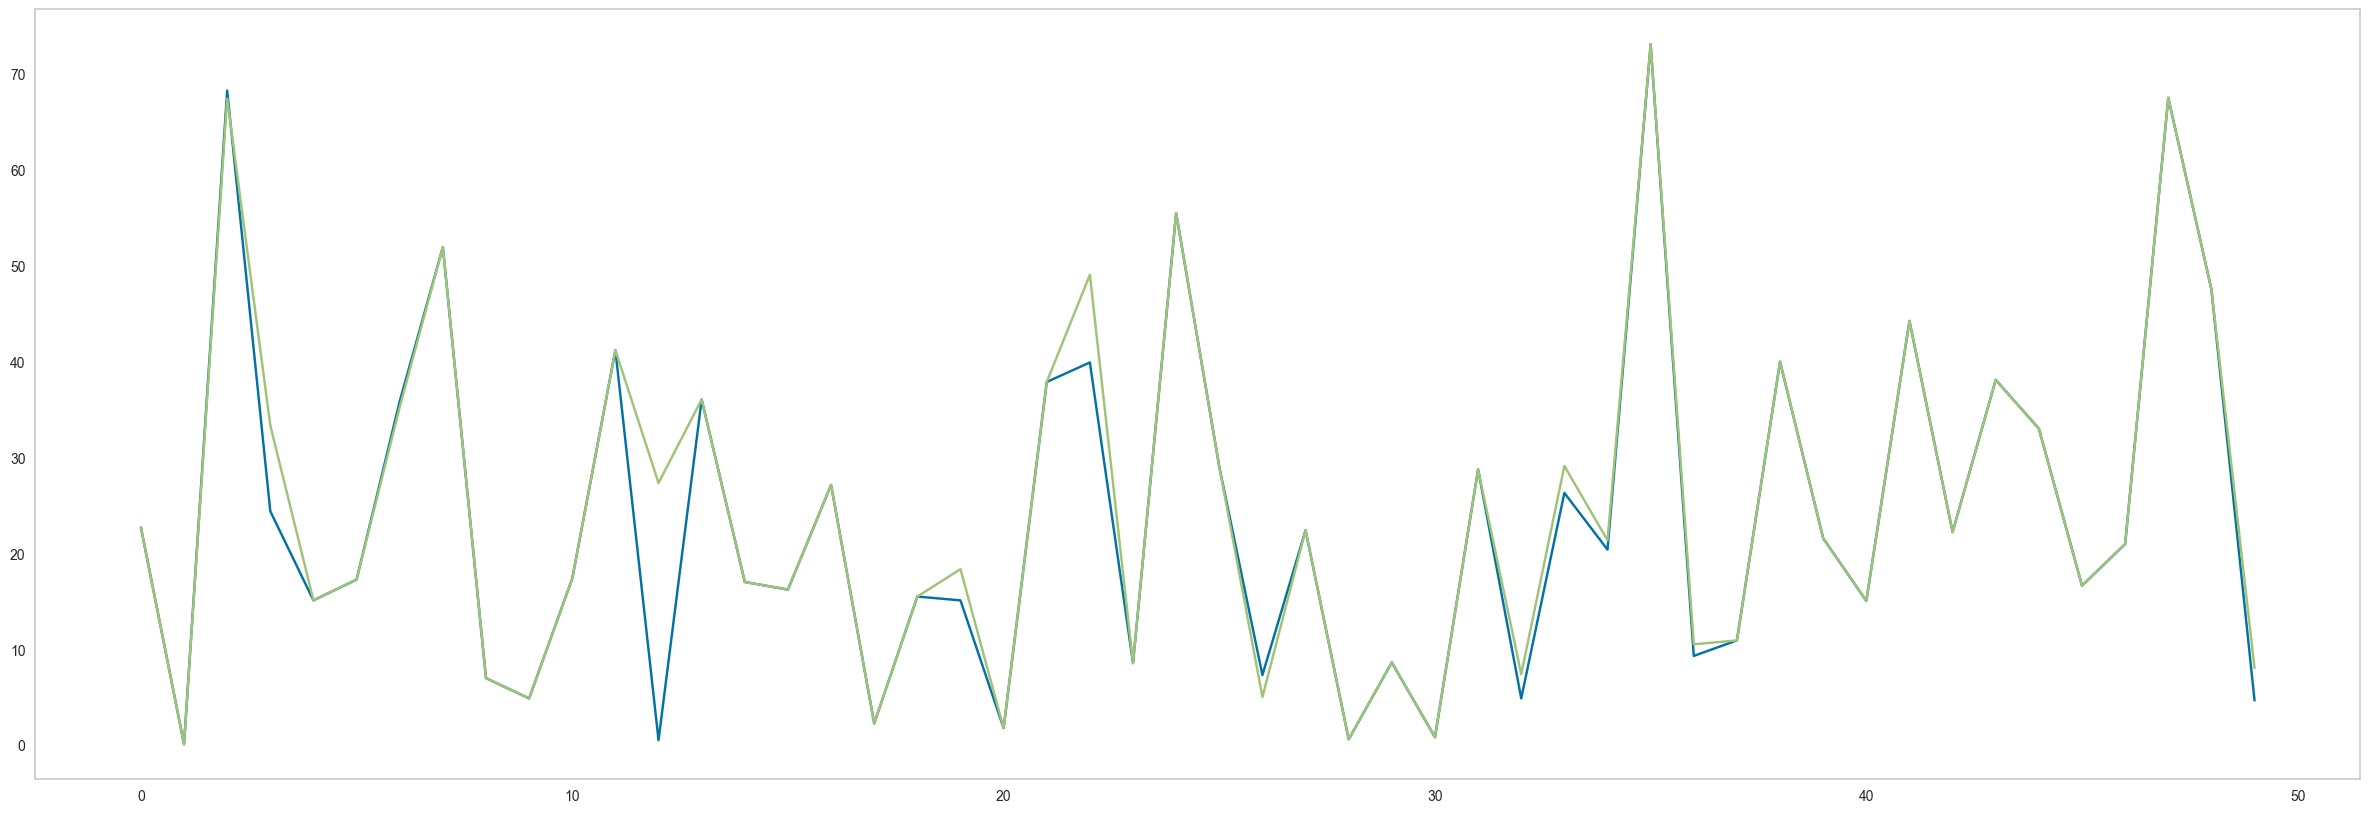

In [174]:
### train:val:test = 7.5:1.25:1.25
train_input, val_input, train_target, val_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target,
                                                                      test_size=0.5, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

param_grid = {'n_neighbors':[3,4,5],
              'metric':['minkowski','manhattan','euclidean'],
              'weights':['uniform','distance']}

grid = GridSearchCV(kn, param_grid=param_grid, cv=3, scoring='r2')

grid.fit(train_input, train_target)

# 찾은 최적모델 사용
kn = grid.best_estimator_
print(grid.get_params())
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_val : ', kn.score(val_input, val_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

# df2

In [178]:
### 정규화
ss = StandardScaler()
X = ss.fit_transform(df2.iloc[:, 7:-1])
y = df2.iloc[:, -1]/86400

In [179]:
### train:val:test = 7.5:1.25:1.25
train_input, val_input, train_target, val_target = train_test_split(X, y,
                                                                      test_size=0.25, random_state=42)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target,
                                                                      test_size=0.5, random_state=42)

# 모델생성
kn = KNeighborsRegressor()

param_grid = {'n_neighbors':[3,4,5],
              'metric':['minkowski','manhattan','euclidean'],
              'weights':['uniform','distance']}

grid = GridSearchCV(kn, param_grid=param_grid, cv=3, scoring='r2')

grid.fit(train_input, train_target)

# 찾은 최적모델 사용
kn = grid.best_estimator_
print(grid.get_params())
print('결정계수_train : ', kn.score(train_input, train_target))
print('결정계수_val : ', kn.score(val_input, val_target))
print('결정계수_test : ', kn.score(test_input, test_target))

# 예측
test_pred = kn.predict(test_input)

# 편차
mse = mean_squared_error(test_target, test_pred)
rmse = mse**(1/2)
print('MSE : ', mse)
print('RMSE : ', rmse)

# 시각화
# 회귀직선을 그려 예측이 잘 되었는지 확인
plt.figure(figsize=(30,10))
plt.plot(range(len(test_target[:50])), test_target[:50]) #true
plt.plot(range(len(test_target[:50])), test_pred[:50]) #predict
plt.grid()

In [ ]:
with open('saved_model2.pickle','wb') as fw:
    pickle.dump(kn, fw)